In [1]:
try:
  #!git clone https://github.com/acen20/CNN-Tensorflow-Keras-for-sound-classification Data
  import os
  os.chdir('/home/mihup/PycharmProjects/cnn-tf-keras-audio-classification/audio')
except:
  print("exception")
  pass 

dataset = 'dataset.npy'
print("ch dir set")

ch dir set


In [2]:
import librosa, librosa.display
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from tensorflow.python.keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.utils import shuffle

2022-01-04 07:28:06.544427: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-04 07:28:06.544454: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Feature Extractor
Uncomment the following block to use your own dataset for training

## Directory Heirarchy
Relative to the location of this script, arrange the folders in the following format:

<b>Drone Sounds:</b> audio/Drone/{drone sounds here}

<b>Other Sounds:</b> audio/{Other}/{Other sounds here}


Processing: 'bg_noise'
audio/bg_noise/bg_noise_56914_6104158998519471_Delhi_9822978376_20200520-200313_20200520-210321_242.wav: 0 1/295
audio/bg_noise/bg_noise_56917_6104159057104211_Delhi_9916595959_20200527-144721_20200527-154747_30.wav: 0 2/295
audio/bg_noise/bg_noise_56903_2494158997240381_Delhi_8920580436_20200520-163002_20200520-172729_229.wav: 0 3/295
audio/bg_noise/bg_noise_56913_6104159014138331_Delhi_9900092870_20200522-152621_20200522-162631_22.wav: 0 4/295
audio/bg_noise/bg_noise_56917_6104159057104211_Delhi_9916595959_20200527-144721_20200527-154747_192.wav: 0 5/295
audio/bg_noise/bg_noise_56906_6109158954118271_Delhi_9886655615_20200515-164301_20200515-174309_136.wav: 0 6/295
audio/bg_noise/bg_noise_56913_6104159014138331_Delhi_9900092870_20200522-152621_20200522-162631_130.wav: 0 7/295
audio/bg_noise/bg_noise_56914_6104158998519471_Delhi_9822978376_20200520-200313_20200520-210321_18.wav: 0 8/295
audio/bg_noise/bg_noise_56914_6104158998519471_Delhi_9822978376_20200520-20

/tmp/ipykernel_88931/3007398276.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  an_array = np.array(data)


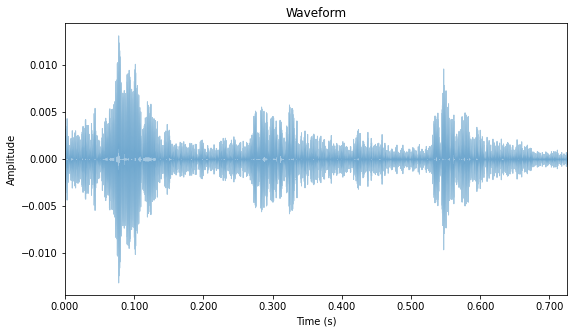

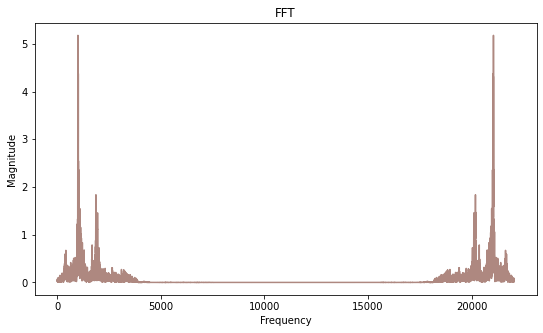

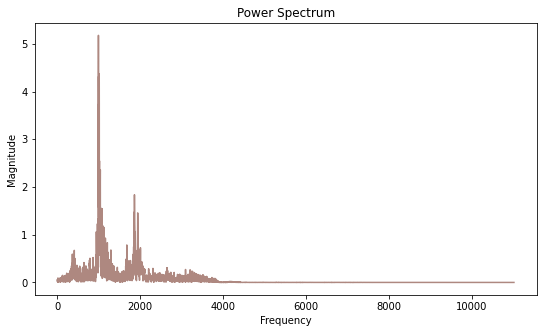

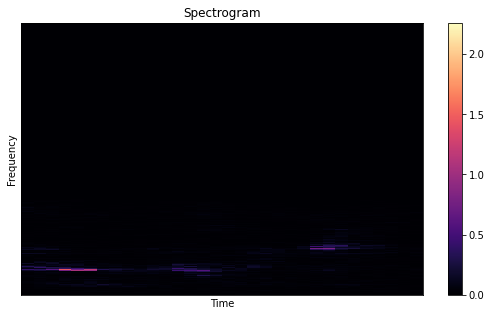

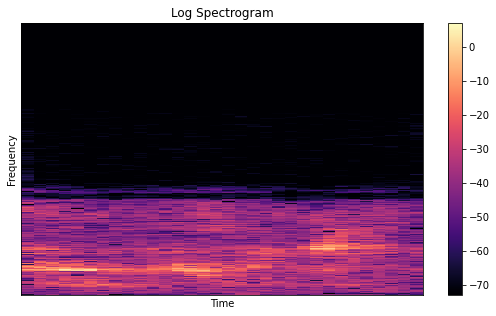

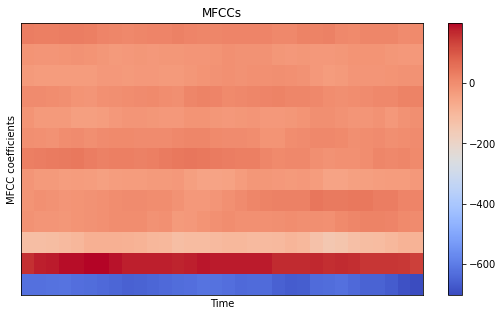

In [5]:
path = "audio/"
min_samples = 16000

waveforms = []
ffts = []
stfts = [] 
f_ffts = []
log_specs = []
MFCCs_list = []


def visualize_signals():
  sample_audio = 1
  FIG_SIZE = (9, 5)

  #Waveform
  plt.figure(figsize = FIG_SIZE)
  waveplot_ = waveforms[sample_audio]
  librosa.display.waveplot(waveplot_[0], sr = waveplot_[1], alpha = 0.4)
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")
  plt.title("Waveform")
  plt.show()

  #Fourier Transformation
  fourier1 = f_ffts[sample_audio]
  plt.figure(figsize=FIG_SIZE)
  plt.plot(fourier1[0], fourier1[1], alpha=0.7, color = "C5")
  plt.xlabel("Frequency")
  plt.ylabel("Magnitude")
  plt.title("FFT")
  plt.show()

  #Power Spectrum
  fourier2 = ffts[sample_audio]
  plt.figure(figsize=FIG_SIZE)
  plt.plot(fourier2[0], fourier2[1], alpha=0.7, color = "C5")
  plt.xlabel("Frequency")
  plt.ylabel("Magnitude")
  plt.title("Power Spectrum")
  plt.show()

  #Spectrogram
  plt.figure(figsize = FIG_SIZE)
  spectrogram_ = stfts[sample_audio]
  librosa.display.specshow(spectrogram_[0], sr=spectrogram_[1], hop_length=spectrogram_[2])
  plt.xlabel("Time")
  plt.ylabel("Frequency")
  plt.colorbar()
  plt.title("Spectrogram")

  #Log Spectrogram
  plt.figure(figsize = FIG_SIZE)
  log_spectrogram_ = log_specs[sample_audio]
  librosa.display.specshow(log_spectrogram_[0], sr=log_spectrogram_[1], hop_length=log_spectrogram_[2])
  plt.xlabel("Time")
  plt.ylabel("Frequency")
  plt.colorbar()
  plt.title("Log Spectrogram")

  #MFCCs
  MFCCs_ = MFCCs_list[sample_audio]
  plt.figure(figsize=FIG_SIZE)
  librosa.display.specshow(MFCCs_[0], sr=MFCCs_[1], hop_length=MFCCs_[2])
  plt.xlabel("Time")
  plt.ylabel("MFCC coefficients")
  plt.colorbar()
  plt.title("MFCCs")



def extract_MFCCs(signal, sample_rate):
    waveforms.append([signal, sample_rate]) 
    # FFT -> power spectrum
    # perform Fourier transform
    fft = np.fft.fft(signal)
    magnitude = np.abs(fft)
    frequency = np.linspace(0, sample_rate, len(magnitude))
    f_ffts.append([frequency, magnitude])
    
    # calculate abs values on complex numbers to get magnitude
    spectrum = np.abs(fft)
    
    # half frequency variable
    f = np.linspace(0, sample_rate, len(spectrum))
    left_spectrum = spectrum[:int(len(spectrum)/2)]
    left_f = f[:int(len(spectrum)/2)]
    
    ffts.append([left_f, left_spectrum])
    
    num_mfcc=13 
    n_fft=1536
    hop_length=512
    
    #performing Short-time FT
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(stft)
    
    stfts.append([spectrogram, sample_rate, hop_length])
    
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    
    log_specs.append([log_spectrogram, sample_rate, hop_length])
    
    MFCCs = librosa.feature.mfcc(signal, sample_rate, 
                                 n_mfcc=num_mfcc, n_fft=n_fft,
                                 hop_length=hop_length)
    MFCCs_list.append([MFCCs, sample_rate, hop_length])
    return MFCCs



def preprocess_dataset(dataset_path):
    data = {
        "mapping": [],
        "labels": [],
        "MFCCs": [],
        #"files": []
    } 
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath is not dataset_path:
            label = dirpath.split("/")[-1]
            data["mapping"].append(label)
            print("\nProcessing: '{}'".format(label))

            # process all audio files in sub-dir and store MFCCs
            counter = 0
            for f in filenames:
                counter += 1
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path)
                if len(signal) >= min_samples:
                    data_to_consider = int(len(signal) - len(signal)%min_samples)
                    iterator_count = int(data_to_consider/min_samples)
                    for val in range(iterator_count):
                        signal_slice = signal[val*min_samples:(val+1)*min_samples]

                        MFCCs = extract_MFCCs(signal_slice, sample_rate)
                        if label == 'bg_noise':
                            llabel = 0
                        elif label == 'dialtone':
                            llabel = 1
                        else:
                            llabel = 2

                        data["MFCCs"].append(MFCCs.T.tolist())
                        data["labels"].append(llabel)
                        #data["files"].append(file_path)
                    print("{}: {} {}/{}".format(file_path, i-1, counter, len(filenames)))
                    
    return data
df = preprocess_dataset(path)
mfcc = np.array(df["MFCCs"])
labels = np.array(df["labels"])
data = list(df.items())
an_array = np.array(data)
dataset = "custom.npy"
visualize_signals()
np.save(dataset, an_array)


# CNN Training
From the top contended (SVM with RBF kernel, Naive Bayes and CNN) algorithms, CNN was chosen for deployment due to its highly discriminative performance

In [3]:
dataset = "custom.npy"
dataset_ = np.load(dataset, allow_pickle = True)

In [4]:
labels = np.array(dataset_[1][1])
mfcc = np.array(dataset_[2][1])
labels, mfcc = shuffle(labels, mfcc, random_state = 42)
breakpoint_ = int(0.05*len(mfcc)) # 5% of the data is used for testing #To Manually split samples into traning and test sets. The integer specifies num of testing samples
test_X = mfcc[:breakpoint_]
mfcc = mfcc[breakpoint_:]
test_y = labels[:breakpoint_]
labels = labels[breakpoint_:]
print(mfcc.shape)
print(labels.shape)
print(test_X.shape)
print(test_y.shape)

(11606, 32, 13)
(11606,)
(610, 32, 13)
(610,)


In [5]:
mfcc.shape

(11606, 32, 13)

In [6]:
unique, counts = np.unique(labels, return_counts=True)
unique, counts

(array([0, 1, 2]), array([4464,  123, 7019]))

In [7]:
classes = np.unique(labels)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  3
Output classes :  [0 1 2]


In [8]:
train_X = mfcc.reshape(-1, 32, 13, 1)
test_X = test_X.reshape(-1, 32, 13, 1)
train_X.shape

(11606, 32, 13, 1)

In [9]:
train_Y_one_hot = to_categorical(labels)
test_y_one_hot = to_categorical(test_y)

In [10]:
test_y_one_hot.shape

(610, 3)

In [11]:
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.20, random_state=42)

In [12]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((9284, 32, 13, 1), (2322, 32, 13, 1), (9284, 3), (2322, 3))

In [26]:
batch_size = 32
epochs = 50
num_classes = 3

In [27]:
model_ = Sequential()
model_.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(32,13,1),padding='same'))
model_.add(LeakyReLU(alpha=0.1))
model_.add(MaxPooling2D((2, 2),padding='same'))
model_.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model_.add(LeakyReLU(alpha=0.1))
model_.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model_.add(LeakyReLU(alpha=0.1))                  
model_.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_.add(Flatten())
model_.add(Dense(128, activation='linear'))
model_.add(LeakyReLU(alpha=0.1))                  
model_.add(Dense(num_classes, activation='softmax'))

In [28]:
model_.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam',metrics=['accuracy'])

In [29]:
lfo_train = model_.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/50
291/291 [==============================] - 6s 18ms/step - loss: 0.6808 - accuracy: 0.9538 - val_loss: 0.1002 - val_accuracy: 0.9737
Epoch 2/50
291/291 [==============================] - 5s 17ms/step - loss: 0.0502 - accuracy: 0.9829 - val_loss: 0.0436 - val_accuracy: 0.9845
Epoch 3/50
291/291 [==============================] - 6s 20ms/step - loss: 0.0326 - accuracy: 0.9890 - val_loss: 0.0399 - val_accuracy: 0.9871
Epoch 4/50
291/291 [==============================] - 5s 17ms/step - loss: 0.0261 - accuracy: 0.9910 - val_loss: 0.0611 - val_accuracy: 0.9806
Epoch 5/50
291/291 [==============================] - 4s 15ms/step - loss: 0.0276 - accuracy: 0.9904 - val_loss: 0.0416 - val_accuracy: 0.9884
Epoch 6/50
291/291 [==============================] - 4s 15ms/step - loss: 0.0226 - accuracy: 0.9925 - val_loss: 0.0225 - val_accuracy: 0.9914
Epoch 7/50
291/291 [==============================] - 4s 15ms/step - loss: 0.0225 - accuracy: 0.9918 - val_loss: 0.0407 - val_accuracy: 0.9866

In [30]:
model_.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_26 (ModuleWra (None, 32, 13, 32)        320       
_________________________________________________________________
module_wrapper_27 (ModuleWra (None, 32, 13, 32)        0         
_________________________________________________________________
module_wrapper_28 (ModuleWra (None, 16, 7, 32)         0         
_________________________________________________________________
module_wrapper_29 (ModuleWra (None, 16, 7, 64)         18496     
_________________________________________________________________
module_wrapper_30 (ModuleWra (None, 16, 7, 64)         0         
_________________________________________________________________
module_wrapper_31 (ModuleWra (None, 8, 4, 64)          0         
_________________________________________________________________
module_wrapper_32 (ModuleWra (None, 8, 4, 128)        

In [31]:
test_X.shape
test_y_one_hot.shape

(610, 3)

In [32]:
test_eval = model_.evaluate(test_X, test_y_one_hot, verbose=0)

In [33]:
test_eval

[0.03761807084083557, 0.9901639223098755]

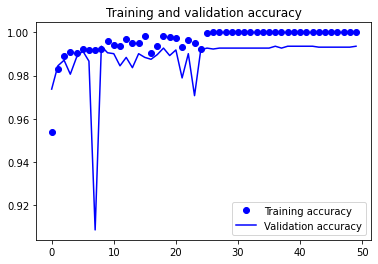

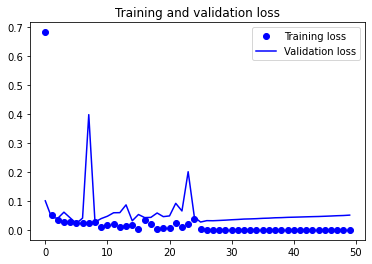

In [34]:
accuracy = lfo_train.history['accuracy']
val_accuracy = lfo_train.history['val_accuracy']
loss = lfo_train.history['loss']
val_loss = lfo_train.history['val_loss']
epochss = range(len(accuracy))
plt.plot(epochss, accuracy, 'bo', label='Training accuracy')
plt.plot(epochss, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochss, loss, 'bo', label='Training loss')
plt.plot(epochss, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

[2 0 2 2 2 0 0 2 2 0 2 0 2 2 2 0 2 2 2 0 2 2 2 0 2 2 2 2 2 0 2 0 0 2 2 0 2
 2 2 2 0 2 0 2 2 2 0 0 0 2 2 0 2 0 2 2 2 0 2 2 0 0 2 0 2 0 0 2 2 2 2 0 0 2
 2 2 2 0 2 0 0 2 2 0 2 0 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 2 0 2 0 2 2
 0 0 2 0 0 2 2 2 0 0 0 2 0 2 2 0 0 0 0 2 2 2 2 2 0 2 2 2 0 2 0 0 2 0 2 2 0
 0 2 2 2 2 2 2 2 0 2 2 0 0 0 0 0 0 2 0 0 0 2 2 2 2 0 0 2 0 2 2 2 0 0 2 2 2
 0 2 2 0 0 0 2 2 2 0 0 2 2 2 2 2 0 0 2 0 2 2 0 2 2 0 2 2 0 2 2 2 2 2 2 0 2
 2 2 2 2 0 0 2 2 0 0 2 2 2 2 2 0 0 0 2 2 2 2 0 0 2 2 2 2 2 0 2 2 2 0 2 0 0
 2 2 2 2 0 0 2 0 2 0 2 2 0 0 2 0 2 0 0 1 0 2 2 0 0 0 2 2 0 2 0 2 2 2 2 2 2
 2 0 2 2 2 0 0 0 2 0 2 2 2 0 0 2 0 0 0 0 2 2 0 2 0 2 2 2 0 2 0 2 2 2 2 2 0
 0 0 2 0 2 2 2 2 2 0 2 0 2 0 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 0 2 0
 2 0 0 0 2 0 0 2 0 0 2 2 0 0 0 2 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2
 2 2 2 0 2 2 2 2 2 0 2 2 0 2 2 2 2 2 2 0 2 2 0 0 2 1 2 0 0 0 2 0 2 1 0 0 2
 0 2 2 0 2 0 2 0 2 2 2 2 2 2 2 0 0 2 0 2 2 0 2 2 2 0 2 2 2 2 2 0 0 0 2 2 0
 0 2 2 0 1 2 2 2 2 2 2 0 

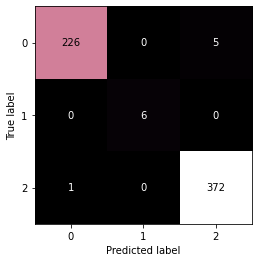

In [35]:
predicted_classes = model_.predict(test_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
print(predicted_classes)
ConfusionMatrixDisplay.from_predictions(test_y, predicted_classes, labels = [0,1,2], cmap="cubehelix", colorbar = 0)

In [36]:
test_acc = len(np.where(predicted_classes == test_y)[0]) / len(test_y)
print(f'CM Acc: {test_acc}')

CM Acc: 0.9901639344262295


# Adding the dropout layer to evaluate generalization

In [37]:
#adding dropout layer
model_ = Sequential()
model_.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(32,13,1)))
model_.add(LeakyReLU(alpha=0.1))
model_.add(MaxPooling2D((2, 2),padding='same'))
model_.add(Dropout(0.25))
model_.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model_.add(LeakyReLU(alpha=0.1))
model_.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_.add(Dropout(0.25))
model_.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model_.add(LeakyReLU(alpha=0.1))                  
model_.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_.add(Dropout(0.4))
model_.add(Flatten())
model_.add(Dense(128, activation='linear'))
model_.add(LeakyReLU(alpha=0.1))           
model_.add(Dropout(0.3))
model_.add(Dense(num_classes, activation='softmax'))

In [38]:
model_.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam",metrics=['accuracy'])

In [39]:
lfo_train_dropout = model_.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/50
291/291 [==============================] - 5s 17ms/step - loss: 1.4815 - accuracy: 0.9072 - val_loss: 0.1118 - val_accuracy: 0.9591
Epoch 2/50
291/291 [==============================] - 5s 17ms/step - loss: 0.1245 - accuracy: 0.9617 - val_loss: 0.0719 - val_accuracy: 0.9729
Epoch 3/50
291/291 [==============================] - 5s 16ms/step - loss: 0.0758 - accuracy: 0.9753 - val_loss: 0.1039 - val_accuracy: 0.9651
Epoch 4/50
291/291 [==============================] - 5s 17ms/step - loss: 0.0627 - accuracy: 0.9780 - val_loss: 0.0839 - val_accuracy: 0.9694
Epoch 5/50
291/291 [==============================] - 5s 16ms/step - loss: 0.0581 - accuracy: 0.9805 - val_loss: 0.6411 - val_accuracy: 0.8290
Epoch 6/50
291/291 [==============================] - 5s 17ms/step - loss: 0.0824 - accuracy: 0.9733 - val_loss: 0.0599 - val_accuracy: 0.9793
Epoch 7/50
291/291 [==============================] - 5s 17ms/step - loss: 0.0521 - accuracy: 0.9827 - val_loss: 0.0620 - val_accuracy: 0.9780

In [40]:
test_eval = model_.evaluate(test_X, test_y_one_hot, verbose=1)

20/20 [==============================] - 0s 7ms/step - loss: 0.0526 - accuracy: 0.9869


In [41]:
test_eval

[0.05258699506521225, 0.9868852496147156]

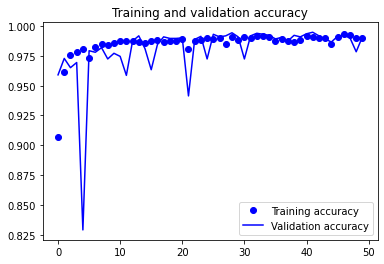

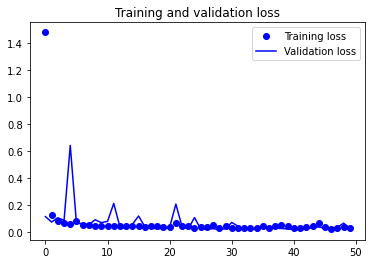

In [42]:
accuracy = lfo_train_dropout.history['accuracy']
val_accuracy = lfo_train_dropout.history['val_accuracy']
loss = lfo_train_dropout.history['loss']
val_loss = lfo_train_dropout.history['val_loss']
epochss = range(len(accuracy))
plt.plot(epochss, accuracy, 'bo', label='Training accuracy')
plt.plot(epochss, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochss, loss, 'bo', label='Training loss')
plt.plot(epochss, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [43]:
predicted_classes = model_.predict(test_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
correct = np.where(predicted_classes==test_y)[0]
print(len(correct)/len(predicted_classes))

0.9868852459016394


predicted_classes:  [[1.12280725e-06 7.01836677e-16 9.99998927e-01]
 [1.00000000e+00 1.99966043e-16 3.81659591e-12]
 [1.11706250e-15 6.08826823e-27 1.00000000e+00]
 ...
 [5.03111948e-15 1.55671161e-26 1.00000000e+00]
 [1.00000000e+00 7.01533170e-21 4.94063883e-14]
 [1.09563825e-05 7.16229918e-14 9.99989033e-01]]


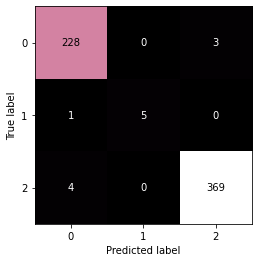

In [44]:
predicted_classes = model_.predict(test_X)
print("predicted_classes: ",predicted_classes)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
ConfusionMatrixDisplay.from_predictions(test_y, predicted_classes, labels = [0,1,2], cmap="cubehelix", colorbar = 0)

In [45]:
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(target_names)
print(classification_report(test_y, predicted_classes, target_names=target_names))

['Class 0', 'Class 1', 'Class 2']
              precision    recall  f1-score   support

     Class 0       0.98      0.99      0.98       231
     Class 1       1.00      0.83      0.91         6
     Class 2       0.99      0.99      0.99       373

    accuracy                           0.99       610
   macro avg       0.99      0.94      0.96       610
weighted avg       0.99      0.99      0.99       610



In [46]:
model_.save("speech_model")

2022-01-04 07:54:40.609397: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: speech_model/assets


INFO:tensorflow:Assets written to: speech_model/assets


In [48]:
loaded_model = keras.models.load_model("speech_model")

In [49]:
predicted_classes = loaded_model.predict(test_X) # 0 =
print("predicted_classes: ",predicted_classes)

predicted_classes:  [[1.12280725e-06 7.01836677e-16 9.99998927e-01]
 [1.00000000e+00 1.99966043e-16 3.81659591e-12]
 [1.11706250e-15 6.08826823e-27 1.00000000e+00]
 ...
 [5.03111948e-15 1.55671161e-26 1.00000000e+00]
 [1.00000000e+00 7.01533170e-21 4.94063883e-14]
 [1.09563825e-05 7.16229918e-14 9.99989033e-01]]
